In [1]:
import pandas as pd
#Regular Expressions - text pattern matching and cleaning text
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
from sklearn.metrics import roc_auc_score,roc_curve
import torch
#transformers
#prepares tweet-like text for models trained on Twitter data
#BertweetTokenizer: prepares tweet-like text for models trained on Twitter data.
#RobertaForSequenceClassification: pre-trained RoBERTa model for classification tasks.
#Trainer & TrainingArguments: handle model training, evaluation, and optimization.
from transformers import BertweetTokenizer,RobertaForSequenceClassification,Trainer,TrainingArguments
#DataCollatorWithPadding: automatically pads variable-length text batches.
#EarlyStoppingCallback: stops training early if validation loss doesn’t improve.
from transformers import DataCollatorWithPadding,EarlyStoppingCallback
#From Hugging Face Datasets, used to easily create and manage datasets.
#Can convert pandas DataFrames into a dataset for use with transformers.
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct 18 07:59:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
#load data

#for running on google colab

from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to CSV inside Drive
file_path = '/content/drive/MyDrive/Datasets/hydrogen_small.csv'

df = pd.read_csv(file_path)

'''df = pd.read_csv("Datasets/hydrogen_small.csv")
df.info()'''

Mounted at /content/drive


'df = pd.read_csv("Datasets/hydrogen_small.csv")\ndf.info()'

In [4]:
df

,label,text
0,Relevant,behind the wheel of a hydrogen powered car
1,Irrelevant,mls measurements of stratospheric hydrogen cya...
2,Relevant,ana gonzalez hernandez shares an overview of h...
3,Relevant,toyota is giving away its first hydrogen car i...
4,Relevant,agility develops storage systems for hydrogen ...
...,...,...
995,Relevant,a solarpower europe report sees europe achievi...
996,Relevant,alstom engiegroup sign a partnership to supply...
997,Relevant,colombia signs a hydrogen mou with the port of...
998,Irrelevant,mr wizard s mini hydrogen bomb via youtube


In [5]:
#a label indicating whether it is relevant
df["label"].unique()

array(['Relevant', 'Irrelevant'], dtype=object)

In [6]:
#examine the messages in the dataset to determine whether any cleaning or pre-processing is necessary
df["text"].iloc[0]

'behind the wheel of a hydrogen powered car'

In [7]:
def clean_message(text):
    #remove URLs from the message.
    #re.sub(pattern, replacement, text)
    #It returns a new string with the replacements made.
    #pattern: the regular expression to search for (what you want to remove or replace).
    #replacement: the string to replace the found pattern with.

    #text: the original text to process.
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    #remove tags from the message
    text = re.sub(r"@\w+", "", text)

    #remove non-ASCII characters from the text
    #like: emojis
    text = re.sub(r"[^\x00-\x7F]+", "", text)

    #replace any sequences of consecutive whitespace with a single space character.
    #This includes newlines and spaces.
    text = re.sub(r"\s+", " ", text)

    #remove whitespace from the start and end of the string
    return text.strip()

In [8]:
#apply it yo the messages in the dataset

df["text"] = df["text"].apply(clean_message)

In [9]:
#examing the message from above to confirm that the tag and URL have been removed
df["text"]

,text
0,behind the wheel of a hydrogen powered car
1,mls measurements of stratospheric hydrogen cya...
2,ana gonzalez hernandez shares an overview of h...
3,toyota is giving away its first hydrogen car i...
4,agility develops storage systems for hydrogen ...
...,...
995,a solarpower europe report sees europe achievi...
996,alstom engiegroup sign a partnership to supply...
997,colombia signs a hydrogen mou with the port of...
998,mr wizard s mini hydrogen bomb via youtube


In [10]:
#pre-processing

from sklearn.preprocessing import LabelEncoder

# create encoder
le = LabelEncoder()

# learn the mapping
le.fit(df["label"])

# transform the original column into numbers
df["label"] = le.transform(df["label"])


df

,label,text
0,1,behind the wheel of a hydrogen powered car
1,0,mls measurements of stratospheric hydrogen cya...
2,1,ana gonzalez hernandez shares an overview of h...
3,1,toyota is giving away its first hydrogen car i...
4,1,agility develops storage systems for hydrogen ...
...,...,...
995,1,a solarpower europe report sees europe achievi...
996,1,alstom engiegroup sign a partnership to supply...
997,1,colombia signs a hydrogen mou with the port of...
998,0,mr wizard s mini hydrogen bomb via youtube


In [11]:
df["label"].value_counts()
#Dataset is much smaller than that in the practical, no need to undersample then.

,count
label,
1,547
0,453


In [12]:
#Split these samples into a training/testing set that we will feed into the model.

X = df["text"].values
y = df["label"].values

In [13]:
random_state = 42

test_set_size = 0.3 # 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, stratify=y, random_state=random_state)
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 700
Testing set size: 300


In [14]:
#tokenizing data

train_df = pd.DataFrame({"text":X_train, "label": y_train})
test_df = pd.DataFrame({"text": X_test, "label":y_test})

#converting DataFrames into Hugging Face datasets
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

In [15]:
#download the embedding model

model_name = "vinai/bertweet-base"
tokenizer = BertweetTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [16]:
#compute the tokens for each of the messages in our dataset

def tokenize(batch):
#batch['text'] takes the "text" column from the dataset
#tokenizer(...) applies the Hugging Face tokenizer
#truncation=True cuts off text longer than the model’s max length.
#padding=True pads shorter texts so that all sequences in a batch have the same length.
    return tokenizer(batch['text'],truncation=True,padding=True)

train_ds = train_ds.map(tokenize,batched=True)
test_ds = test_ds.map(tokenize,batched=True)

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [17]:
train_ds

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 700
})

In [18]:
# Loading the Model
# With the data ready to train the model we are using for transfer learning
# need to download and load the base model.

#in case there is a model assigned to this variable name

try:
    del model
except NameError:
    pass

#Download/load the base model. We use the "vinai/bertweet-base" model here.
#set the number of labels to 2
#set the problem type to single label classification
#loads a RoBERTa model that’s already trained on language data (from Hugging Face)

model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    #sets how many output classes the model should predict
    num_labels=df["label"].nunique(),
    problem_type="single_label_classification"
)

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
#Training the Model
#define the metrics to compute after each epoch
#define a metrics computing function compatible with the `transformers` library

#This function tells the Hugging Face Trainer how to evaluate model after each epoch.

# pred is an object the Trainer provides.
# It contains:
# pred.predictions: the raw model outputs (logits) — basically unnormalized scores for each class.
# pred.label_ids: the true labels from dataset.

def compute_metrics(pred):
    labels = pred.label_ids
    #convert model outputs to predicted classes
    preds = pred.predictions.argmax(-1) #argmax(-1) picks the index of the highest value (largest logit) along the last axis.
    acc = accuracy_score(labels,preds)
    prec,recall,f1,_ = precision_recall_fscore_support(
        labels, preds, average="binary", pos_label=1
    )
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": recall,
        "f1":f1
    }


In [20]:
#set up hyperparameters for the training process

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [21]:
#for running this on google colab, use Qia Zou's key: 400ca2a60c63ab75928d7e7e190450c4ca02b675

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)
trainer.train()

#Epoch	Training Loss	Validation Loss	Accuracy	Precision	Recall	F1
#1	0.381000	0.337171	0.883333	0.852459	0.951220	0.899135
#2	0.250200	0.290129	0.903333	0.864865	0.975610	0.916905


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: qzou1122 (qzou1122-queensland-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.609400,0.553277,0.803333,0.735426,1.000000,0.847545
2,0.460900,0.423856,0.900000,0.856383,0.981707,0.914773


TrainOutput(global_step=88, training_loss=0.5698323927142404, metrics={'train_runtime': 134.0607, 'train_samples_per_second': 10.443, 'train_steps_per_second': 0.656, 'total_flos': 53958321900000.0, 'train_loss': 0.5698323927142404, 'epoch': 2.0})

In [22]:
#Model Evaluation
#switch the model to evaluation mode

model.eval()

train_results = trainer.evaluate(train_ds)
test_results = trainer.evaluate(test_ds)

In [23]:
#display the results

def display_evaluation(setname, results):
    print(f"{setname} Set Accuracy:", round(results["eval_accuracy"], 3))
    print(f"{setname} Set Precision:", round(results["eval_precision"], 3))
    print(f"{setname} Set Recall:", round(results["eval_recall"], 3))
    print(f"{setname} Set F1 score:", round(results["eval_f1"], 3))

display_evaluation("Training", train_results)
display_evaluation("Testing", test_results)

#Training Set Accuracy: 0.936
#Training Set Precision: 0.908
#Training Set Recall: 0.982
#Training Set F1 score: 0.944
#Testing Set Accuracy: 0.903
#Testing Set Precision: 0.865
#Testing Set Recall: 0.976
#Testing Set F1 score: 0.917




Training Set Accuracy: 0.907
Training Set Precision: 0.868
Training Set Recall: 0.979
Training Set F1 score: 0.92
Testing Set Accuracy: 0.9
Testing Set Precision: 0.856
Testing Set Recall: 0.982
Testing Set F1 score: 0.915


In [33]:
#further subsample thedataset

_, X_small, _, y_small = train_test_split(
    X, y, stratify=y, test_size=0.001, random_state=random_state
)

X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(
    X_small, y_small, stratify=y_small, test_size=0.3, random_state=random_state
)

small_train_df = pd.DataFrame({
    "text": X_small_train,
    "label": y_small_train
})

small_test_df = pd.DataFrame({
    "text": X_small_test,
    "label": y_small_test
})

small_train_ds = Dataset.from_pandas(small_train_df)
small_test_ds = Dataset.from_pandas(small_test_df)

small_train_ds = small_train_ds.map(tokenize, batched=True)
small_test_ds = small_test_ds.map(tokenize, batched=True)

print("Small training set size:", len(small_train_df))
print("Small testing set size:", len(small_test_df))


Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Small training set size: 70
Small testing set size: 30


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.676624,0.566667,0.566667,1.000000,0.723404
2,0.682600,0.669017,0.566667,0.566667,1.000000,0.723404
3,0.682600,0.655115,0.566667,0.566667,1.000000,0.723404
4,0.643300,0.636571,0.566667,0.566667,1.000000,0.723404
5,0.643300,0.611161,0.600000,0.586207,1.000000,0.739130
6,0.572800,0.579453,0.700000,0.653846,1.000000,0.790698
7,0.572800,0.540933,0.833333,0.800000,0.941176,0.864865
8,0.493700,0.497910,0.833333,0.800000,0.941176,0.864865
9,0.493700,0.455220,0.866667,0.842105,0.941176,0.888889
10,0.351900,0.423491,0.866667,0.842105,0.941176,0.888889


TrainOutput(global_step=80, training_loss=0.40706333667039873, metrics={'train_runtime': 842.0625, 'train_samples_per_second': 4.156, 'train_steps_per_second': 0.297, 'total_flos': 33957770582400.0, 'train_loss': 0.40706333667039873, 'epoch': 16.0})

In [35]:
#Examining Attention Weights

# Returns (attentions, pred_class, tokens)
def compute_attention_matrix(tokenizer, model, text):
    # Tokenize text and move tensors to the same device as the model
    tokens = tokenizer(text, return_tensors="pt").to(model.device)

    # Disable gradient updates for inference
    with torch.no_grad():
        pred = model(**tokens, output_attentions=True)

    # Stack attention layers and move to CPU
    attentions = torch.stack(pred.attentions).cpu()

    # Remove batch dimension
    attentions = attentions.squeeze(1)

    # Average across layers and heads
    attentions = attentions.mean(dim=0).mean(dim=0)

    # Get predicted class
    pred_class = pred.logits.cpu().argmax(-1).item()

    # Convert token IDs to readable strings
    token_strs = tokenizer.convert_ids_to_tokens(tokens["input_ids"][0])

    return attentions, pred_class, token_strs

def plot_attention(attentions, tokens, title):
    # Enlarge figure to take up more of the width
    plt.figure(figsize=(10, 8))
    plt.title(title)

    # Plot heatmap
    sns.heatmap(
        attentions,
        xticklabels=tokens,   # Display token names on X axis
        yticklabels=tokens,   # Display token names on Y axis
        cmap='binary',        # Black for low, white for high
        cbar=True             # Display colour bar
    )

    plt.show()

def display_attention_matrix(tokenizer, model, text):
    attention, pred_class, tokens = compute_attention_matrix(tokenizer, model, text)

    pred_label = "Positive" if pred_class == 1 else "Negative"

    plot_attention(
        attention,
        tokens,
        text + f"\nPredicted class: {pred_label}"
    )

RobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


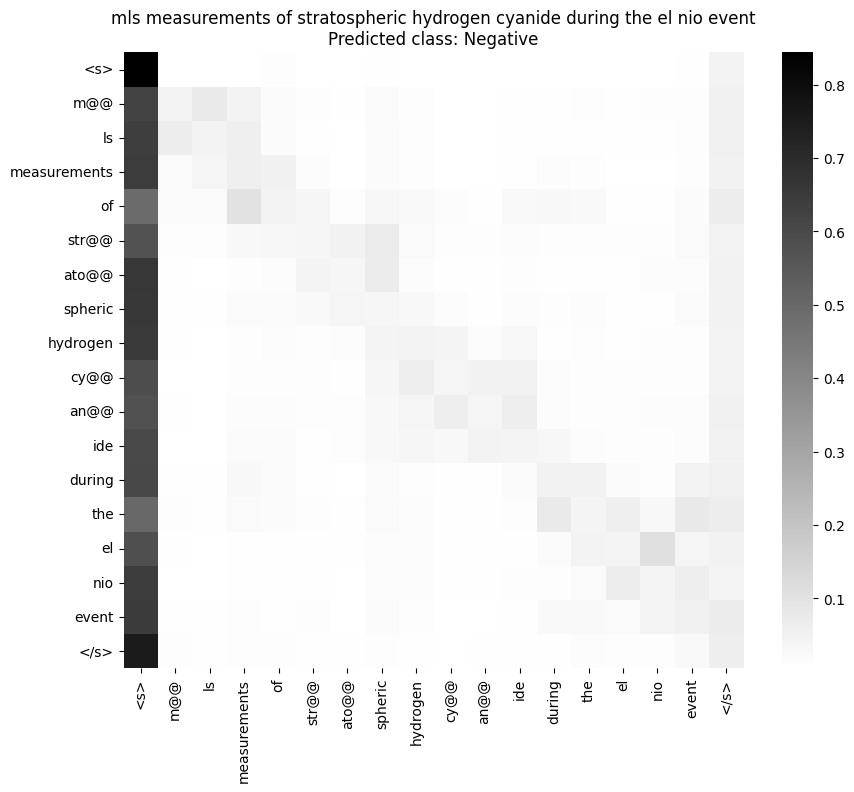

In [36]:
display_attention_matrix(
    tokenizer,
    model,
    df[df["label"] == 0].iloc[0]["text"]
)


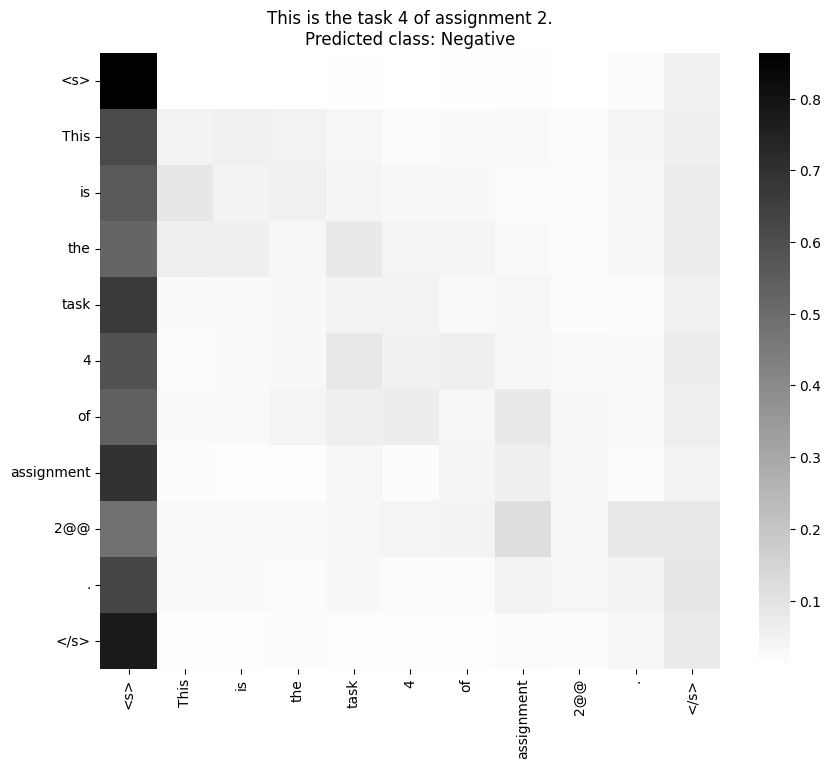

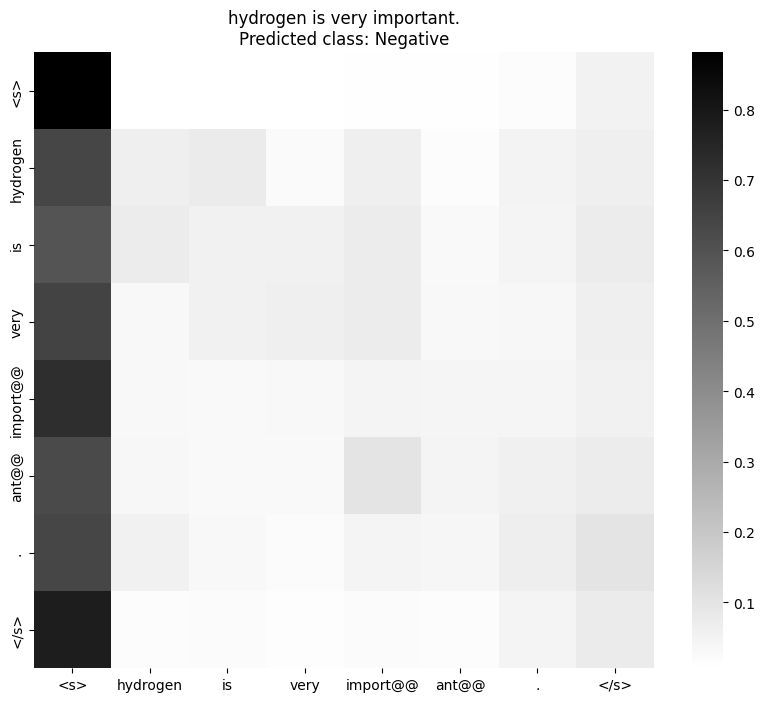

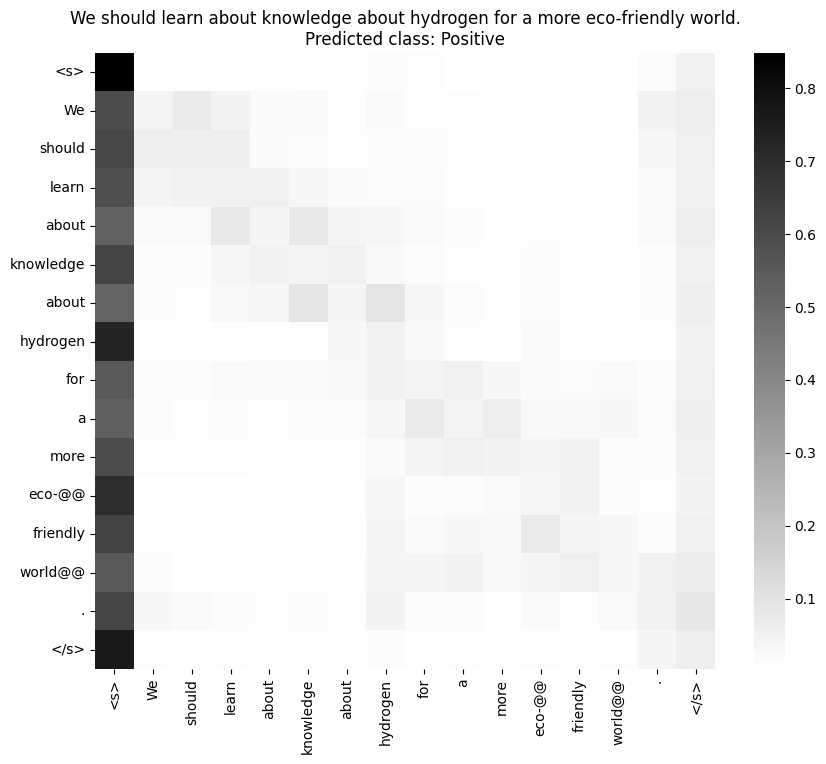

In [39]:
display_attention_matrix(
    tokenizer,
    model,
    "This is the task 4 of assignment 2."
)

display_attention_matrix(
    tokenizer,
    model,
    "hydrogen is very important."
)

display_attention_matrix(
    tokenizer,
    model,
    "We should learn about knowledge about hydrogen for a more eco-friendly world."
)

/tmp/ipython-input-3965754602.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probs = torch.nn.functional.softmax(


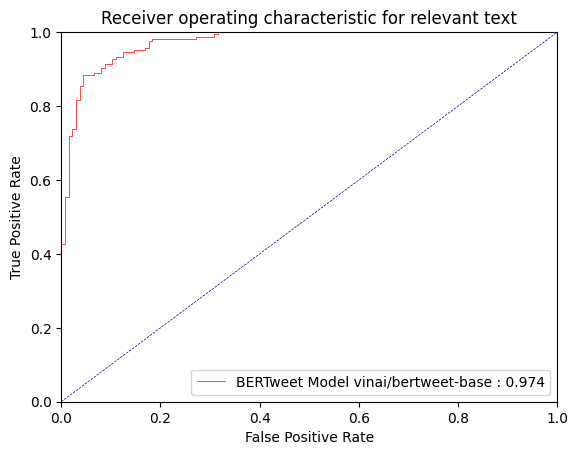

In [46]:
#Computing the ROC Curve

pred = trainer.predict(test_ds)

# Convert to PyTorch tensor, apply softmax, and convert back to a NumPy array
pred_probs = torch.nn.functional.softmax(
    torch.Tensor(pred.predictions)
).numpy()

#plot the ROC curve

# Compute the ROC index. Recall y_test contains our original labels for the testing set.
roc_index_nn = roc_auc_score(y_test, pred_probs[:, 1])

# Compute the ROC curve.
fpr_nn, tpr_nn, bertweet_thresholds_nn = roc_curve(y_test, pred_probs[:, 1])

# And plot it on a line graph
plt.plot(
    fpr_nn,
    tpr_nn,
    label="BERTweet Model vinai/bertweet-base : {:.3f}".format(roc_index_nn),
    color='red',
    lw=0.5
)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic for relevant text")
plt.legend(loc="lower right")
plt.show()



### build a logistic regression baseline model

In [47]:
#build a logistic regression baseline model

#load data

#for running on google colab

from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to CSV inside Drive
tfidf_file_path = '/content/drive/MyDrive/Datasets/tfidf_features_small.csv'

tfidf_df = pd.read_csv(tfidf_file_path)

#for running locally use the code below
'''df = pd.read_csv("Datasets/tfidf_features_small.csv")
df.info()'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'df = pd.read_csv("Datasets/hydrogen_small.csv")\ndf.info()'

In [50]:
tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 4981 entries, aaa to 論文１
dtypes: float64(4981)
memory usage: 38.0 MB


df

In [51]:
df

,label,text
0,1,behind the wheel of a hydrogen powered car
1,0,mls measurements of stratospheric hydrogen cya...
2,1,ana gonzalez hernandez shares an overview of h...
3,1,toyota is giving away its first hydrogen car i...
4,1,agility develops storage systems for hydrogen ...
...,...,...
995,1,a solarpower europe report sees europe achievi...
996,1,alstom engiegroup sign a partnership to supply...
997,1,colombia signs a hydrogen mou with the port of...
998,0,mr wizard s mini hydrogen bomb via youtube


In [ ]:
#pre-precessing

#regression modelling
#bulding a default model

'''from sklearn.model_selection import train_test_split

# Obtain a list of labels (targets) for each of the samples.
Y = df['	label	']
X = tfidf_df


# Create a 30% train/test split from the samples.

random_state = 10
test_set_size = 0.3 # 30%
X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values,
test_size=test_set_size, stratify=Y, random_state=random_state)

print("Size of training set:", len(X_train))
print("Size of testing set:", len(X_test))

#Task 3.1

#Task 3.1. additional processing

#normalization

from sklearn.preprocessing import StandardScaler

print("Before scaling\n-------------")
for i in range(X_train.shape[1]):
    col = X_train[:, i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".format(
        i, min(col), max(col), np.mean(col), np.std(col)))

random_seed = 10
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)




print("After scaling\n-------------")
for i in range(X_train.shape[1]):
    col = X_train[:, i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".format(
        i, min(col), max(col), np.mean(col), np.std(col)))

'''


In [53]:
#pre-precessing

#regression modelling
#bulding a default model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.model_selection import train_test_split

# Extract labels (target) and TF-IDF features
y_tfidf = df["label"]
X_tfidf = tfidf_df

# Split data into training and testing sets (70% / 30%)
random_state = 10
test_set_size = 0.3  # 30%

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf.values,
    y_tfidf.values,
    test_size=test_set_size,
    stratify=y_tfidf,
    random_state=random_state
)

print("Size of training set:", len(X_train_tfidf))
print("Size of testing set:", len(X_test_tfidf))

# --- Normalization / Standardization ---

print("\nBefore scaling\n----------------")
for i in range(min(X_train_tfidf.shape[1], 5)):  # show first 5 variables only
    col = X_train_tfidf[:, i]
    print(
        f"Variable #{i}: min {min(col)}, max {max(col)}, "
        f"mean {np.mean(col):.2f}, std dev {np.std(col):.2f}"
    )

# Initialize and apply scaler
scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse TF-IDF data
X_train_tfidf = scaler.fit_transform(X_train_tfidf, y_train_tfidf)
X_test_tfidf = scaler.transform(X_test_tfidf)

print("\nAfter scaling\n----------------")
for i in range(min(X_train_tfidf.shape[1], 5)):
    col = X_train_tfidf[:, i].toarray().flatten() if hasattr(X_train_tfidf, "toarray") else X_train_tfidf[:, i]
    print(
        f"Variable #{i}: min {min(col)}, max {max(col)}, "
        f"mean {np.mean(col):.2f}, std dev {np.std(col):.2f}"
    )

Size of training set: 700
Size of testing set: 300

Before scaling
----------------
Variable #0: min 0.0, max 0.3326228568127624, mean 0.00, std dev 0.01
Variable #1: min 0.0, max 0.2231565956183712, mean 0.00, std dev 0.01
Variable #2: min 0.0, max 0.0, mean 0.00, std dev 0.00
Variable #3: min 0.0, max 0.273780541412464, mean 0.00, std dev 0.01
Variable #4: min 0.0, max 0.0, mean 0.00, std dev 0.00

After scaling
----------------
Variable #0: min 0.0, max 26.476431606528212, mean 0.04, std dev 1.00
Variable #1: min 0.0, max 26.476431606528198, mean 0.04, std dev 1.00
Variable #2: min 0.0, max 0.0, mean 0.00, std dev 0.00
Variable #3: min 0.0, max 26.476431606528344, mean 0.04, std dev 1.00
Variable #4: min 0.0, max 0.0, mean 0.00, std dev 0.00


In [54]:
#Training logistic Regression

#training
#a default model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize model
model = LogisticRegression(random_state=random_state)

# Train model on training data
model.fit(X_train_tfidf, y_train_tfidf)

# Evaluate model
print("Train accuracy:", model.score(X_train_tfidf, y_train_tfidf))
print("Test accuracy:", model.score(X_test_tfidf, y_test_tfidf))

# Classification report on test data
y_pred_tfidf = model.predict(X_test_tfidf)
print(classification_report(y_test_tfidf, y_pred_tfidf))

Train accuracy: 1.0
Test accuracy: 0.82
              precision    recall  f1-score   support

           0       0.88      0.70      0.78       136
           1       0.79      0.92      0.85       164

    accuracy                           0.82       300
   macro avg       0.83      0.81      0.81       300
weighted avg       0.83      0.82      0.82       300



In [ ]:
#Produce the ROC curve for regression model

#get ROC index

from sklearn.metrics import roc_auc_score

y_pred_proba_log_cv = .predict_proba(X_tes)
print("ROC index on test for `log_cv`:", )

#plot ROC curve

from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

plt.plot(
    , ,
    label=',
    color='navy', lw=0.5
)

# Baseline (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


ROC-AUC index on test (TF-IDF Logistic Regression): 0.9401901004304161


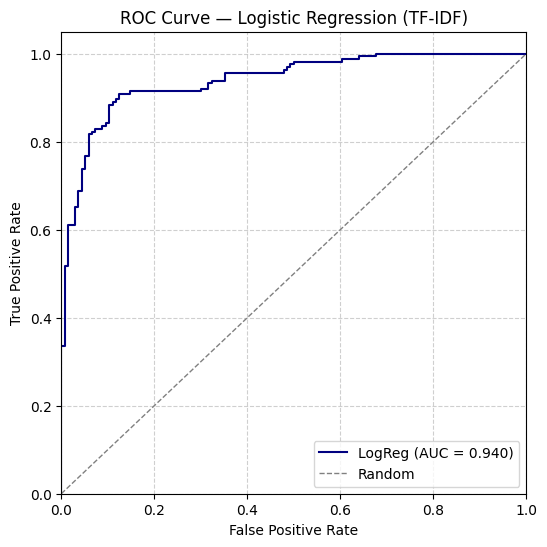

In [55]:
#Produce the ROC curve for regression model

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

#get ROC index
y_pred_proba_tfidf = model.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test_tfidf, y_pred_proba_tfidf)
print("ROC-AUC index on test (TF-IDF Logistic Regression):", roc_auc)

# Compute ROC curve points
fpr, tpr, thresholds = roc_curve(y_test_tfidf, y_pred_proba_tfidf)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='navy', lw=1.5, label=f'LogReg (AUC = {roc_auc:.3f})')

# Baseline (random guess)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')

# Plot formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Logistic Regression (TF-IDF)')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


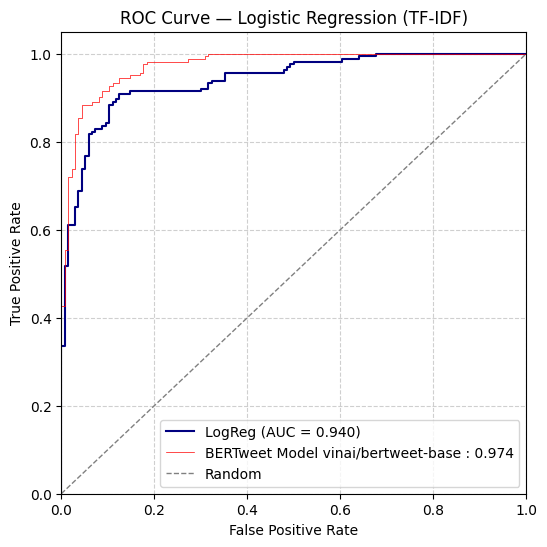

In [57]:
#plot both models together


# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='navy', lw=1.5, label=f'LogReg (AUC = {roc_auc:.3f})')

plt.plot(
    fpr_nn,
    tpr_nn,
    label="BERTweet Model vinai/bertweet-base : {:.3f}".format(roc_index_nn),
    color='red',
    lw=0.5
)


# Baseline (random guess)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')

# Plot formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Logistic Regression (TF-IDF)')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()






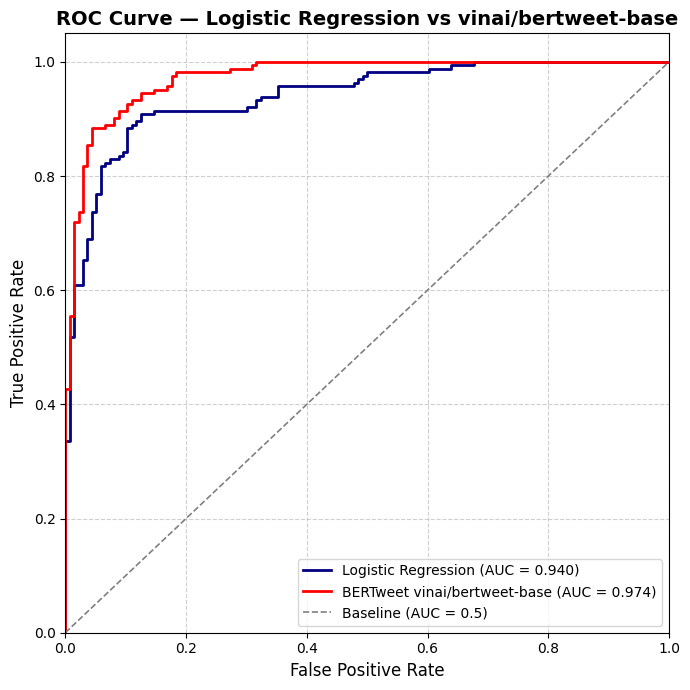

In [61]:
import matplotlib.pyplot as plt

# Plot both ROC curves together
plt.figure(figsize=(7, 7))

# Logistic Regression curve (TF-IDF baseline)
plt.plot(
    fpr,
    tpr,
    color='navy',
    lw=2,
    label=f'Logistic Regression (AUC = {roc_auc:.3f})'
)

# BERTweet fine-tuned model curve
plt.plot(
    fpr_nn,
    tpr_nn,
    color='red',
    lw=2,
    label=f'BERTweet vinai/bertweet-base (AUC = {roc_index_nn:.3f})'
)

# baseline
plt.plot(
    [0, 1], [0, 1],
    color='gray',
    lw=1.2,
    linestyle='--',
    label='Baseline (AUC = 0.5)'
)

# --- Formatting & Labels ---
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve — Logistic Regression vs vinai/bertweet-base', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
#save the ROC outputs of the best regression model (optional)

'''import pickle

lr_best = model
roc_index_lr_best = roc_index_model
tpr_lr_best = tpr_model
fpr_lr_best = fpr_model

with open('LR.pickle', 'wb') as f:
    pickle.dump([lr_best, roc_index_lr_best, fpr_lr_best, tpr_lr_best], f)'''
